# Описание проекта

Проект выполняется в интересах добывающей компании «ГлавРосГосНефть». Цель проекта - определить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. В рамках проекта будет обучена модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможная прибыль и риски будут оценены техникой *Bootstrap*.

Методика для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:

- Данные геологоразведки трёх регионов находятся в файлах:
geo_data_0.csv
geo_data_1.csv
geo_data_2.csv;
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# зачитаем данные
# у нас будет много однотипных данных для каждого из регионов, договоримся использовать списки для их сохранения
regions = [i for i in range(3)] # регионы будут адресоваться просто 0, 1, 2, для наглядности кода сформируем список 
data = [] 
for region in regions:
    file_name = f'/datasets/geo_data_{region}.csv'
    data.append(pd.read_csv(file_name))

In [3]:
# посмотрим пропуски и тип данных
for region in regions:
    print(f'Region:  {region}')
    print(data[region].info())
    display(data[region].head())
    print()

Region:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Region:  1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Region:  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
# выделим признаки и цели, затем разобьем данные на обучающие и валидационные выборки
SPLIT_RANDOM_STATE = 134
VALID_SIZE = .25
x_train, y_train, x_valid, y_valid = [], [], [], []

for region in regions:
    x_i = data[region].drop(columns=['product', 'id'])
    y_i = data[region]['product']
    x_train_i, x_valid_i, y_train_i, y_valid_i = train_test_split(x_i, y_i, test_size=VALID_SIZE, random_state=SPLIT_RANDOM_STATE)
    x_train.append(x_train_i)
    x_valid.append(x_valid_i)
    y_train.append(y_train_i)
    y_valid.append(y_valid_i)

In [5]:
# убедимся в правильности разбивки
for region in regions:
    print(f'Region: {region}, X train size: {x_train[region].shape}, y train size: {y_train[region].shape}')
    print(f'X valid size: {x_valid[region].shape}, y valid size: {y_valid[region].shape}')

Region: 0, X train size: (75000, 3), y train size: (75000,)
X valid size: (25000, 3), y valid size: (25000,)
Region: 1, X train size: (75000, 3), y train size: (75000,)
X valid size: (25000, 3), y valid size: (25000,)
Region: 2, X train size: (75000, 3), y train size: (75000,)
X valid size: (25000, 3), y valid size: (25000,)


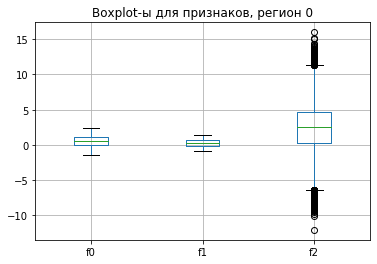

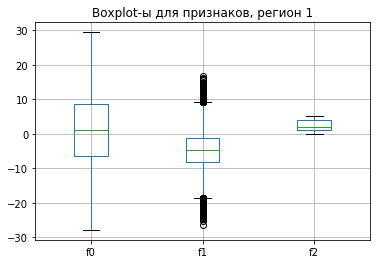

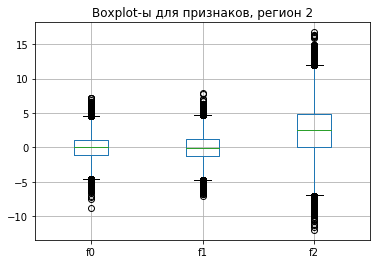

In [6]:
# посмотрим на разброс признаков
for region in regions:
    x_train[region].boxplot()
    plt.title(f'Boxplot-ы для признаков, регион {region}')
    plt.show()

In [7]:
# масштабируем признаки
scaler = []
for region in regions:
    scaler_i = StandardScaler()
    scaler_i.fit(x_train[region])
    x_train[region] = scaler_i.transform(x_train[region])
    x_valid[region] = scaler_i.transform(x_valid[region])
    scaler.append(scaler_i)

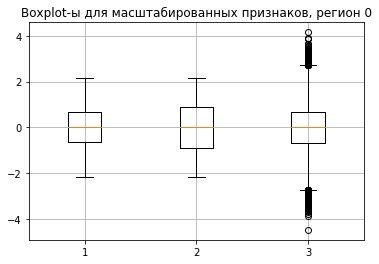

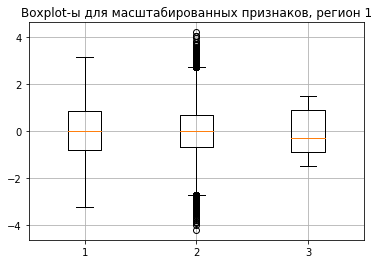

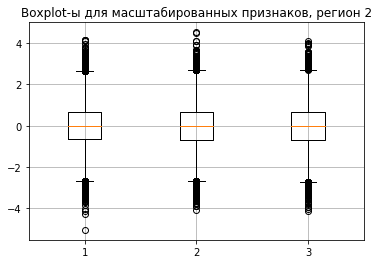

In [8]:
# визуализируем результат масштабирования
for region in regions:
    plt.boxplot(x_train[region])
    plt.title(f'Boxplot-ы для масштабированных признаков, регион {region}')
    plt.grid()
    plt.show()

## Выводы
- По каждому региону представлены данные по 100000 объектов.
- Все данные полны, пропуски не обнаружены.
- Распределение значений для одних и тех же признаков в разных регионах существенно отличаются друг друга.
- Была произведена разбивка данных  на обучающие и валидационные наборы в каждом регионе в пропорции 3 к 1.

# 2. Обучение и проверка модели

In [9]:
# обучим модели линейной регрессии для каждого региона и сохраним их, 
# сделаем и сохраним предсказания на валидационных выборках,
# посчитаем и сохраним rmse для каждого региона

models = [] #  список для сохранения моделей для каждого региона
predictions = [] # список серий для каждого региона, в каждой серии будут сохранены предсказания модели, 
# причем индексы серий будут соответствовать таргетам тех же валидационных выборок 
errors = [] # список rmse ошибок для каждого региона

for region in regions:
    model_i = LinearRegression().fit(x_train[region], y_train[region])
    models.append(model_i)
    prediction_i = model_i.predict(x_valid[region])
    prediction_i = pd.Series(prediction_i, index=y_valid[region].index)
    predictions.append(prediction_i)
    rmse_i = mean_squared_error(y_valid[region], predictions[region]) ** 0.5
    errors.append(rmse_i)
    print(f'Регион: {region}, средний запас скважины в предсказании модели: {prediction_i.mean():5.2f}, среднеквадратичная ошибка предсказания {rmse_i:5.2f}')

Регион: 0, средний запас скважины в предсказании модели: 92.56, среднеквадратичная ошибка предсказания 37.39
Регион: 1, средний запас скважины в предсказании модели: 68.64, среднеквадратичная ошибка предсказания  0.89
Регион: 2, средний запас скважины в предсказании модели: 95.05, среднеквадратичная ошибка предсказания 40.21


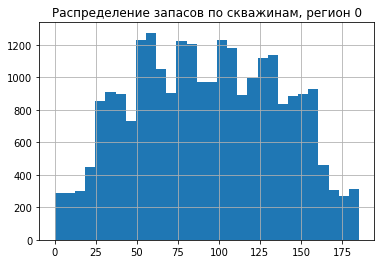

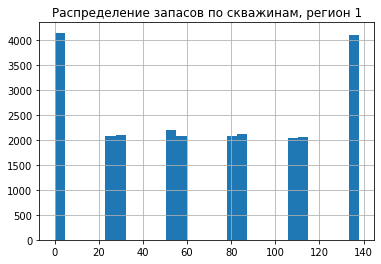

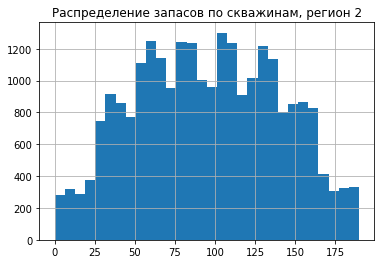

In [10]:
# среднее значение в районе №1 сильно отличается от двух других районов, 
# посмотрим на реальное распределение запасов по скважинам в каждом районе в валидационных выборках
for region in regions:
    plt.hist(y_valid[region], bins=30)
    plt.title(f'Распределение запасов по скважинам, регион {region}')
    plt.grid()
    plt.show()

## Выводы:
- В регионах 0 и 2 средний запас скважины значительно выше, чем средний запас скважины в регионе 1.
- Распределение реальных запасов по скважинам в регионе №1 существенно отличается от распределений в регионах 0 и 2.  В регионах 0 и 2 распределение колоколообразные, среднее примерно соответствует вершине колокола, в регионе 1 распределение напоминает воронку - минимум в центре примерно соответствует среднему, максимумы по краям в районе минимальных и максимальных запасов.
- Кроме того обученная нами модель, предсказывающая запас каждой скважины, в регионе 1 значительно точнее, что позволит выбирать лучшие для бурения скважины в этом районе с гораздо мЕньшим риском ошибки. 

# 3. Подготовка к расчёту прибыли

In [11]:
# заданы некоторые числа для экономического расчета в условиях проекта, присвоим их соотв. константам
BUDGET_PER_REGION = 10000 # общий бюджет для бурения в одном регионе, в млн. руб.
WELLs_IN_REGION_FOR_DRILLING = 200 # кол-во скважин в регионе, которые будут пробурены для добычи
INCOME_PER_UNIT = .45 # доход в млн. руб., полученный с одной единицы сырья, кол-во единиц представлено в столбце product наших данных

In [12]:
# посчитаем, какой объем добычи должен быть в среднем у одной скважины для безубыточности и сравним со средними значениями в регионе
print(f'Безубыточный минимум в средней скважине: {BUDGET_PER_REGION / WELLs_IN_REGION_FOR_DRILLING / INCOME_PER_UNIT:5.2f}')


Безубыточный минимум в средней скважине: 111.11


## Выводы:
- Нам необходимо выбрать регионы для бурения, при этом средний запас в скважине в регионах 0 и 2 ниже безубыточного уровня  на 15-18%
- В регионе № 1 средний запас в скважине ниже безубыточного уровня почти на 40%, однако в данном регионе: 
 - во-первых, распределение запасов по скважинам имеет необычный вид - максимум кол-ва скважин находится в "хвостах" распределения, в районе нулевых запасов и максимальных запасов,
 - во-вторых, модель, предсказывающая запас сырья в скважине, значительно точнее, что, естественно, должно сократить вероятность ошибки при выборе лучших, а, значит, и риски. Проверим на этапе моделирования прибыли и рисков.

# 4. Расчёт прибыли и рисков 

In [13]:
# для расчета прибыли и рисков будем моделировать добычу в каждом регионе, воспользовавшись техникой bootstrap
# для этого создадим функцию, подсчитывающую возможную прибыль добычи в отдельном регионе,
# в качестве параметров в функцию передаются данные прогноза модели и реальные данные запасов каждой скважины
# по данным прогноза (по предсказанию модели) выбирается заданное количество (wells_in_region) лучших скважин 
# прибыль считается, исходя из реальных запасов выбранных скважин
def profit_from_region(predicted_products, real_products):
    selected_predictions = predicted_products.sort_values(ascending=False).head(WELLs_IN_REGION_FOR_DRILLING)
    selected_products = real_products[selected_predictions.index]
    return selected_products.sum() * INCOME_PER_UNIT - BUDGET_PER_REGION

In [14]:
WELLs_IN_REGION_FOR_CHOOSING = 500 # кол-во скважин, из которых выбираются 200 лучших для бурения, задано условиями проекта
state = np.random.RandomState(134)

mean_revenue_in_region = []
# сохраним все полученные в результате моделирования значения прибыли в dataframe для удобства последующей визуализации
bootstrap_profits_all_regions = pd.DataFrame() 


for region in regions:
    bootstrap_profits = []
    for i in range(1000): 
        bootstrap_real_products = y_valid[region].sample(n=WELLs_IN_REGION_FOR_CHOOSING, random_state=state, replace=True) 
        bootstrap_predicted_products = predictions[region][bootstrap_real_products.index] 
        bootstrap_profits.append(profit_from_region(bootstrap_predicted_products, bootstrap_real_products))
    bootstrap_profits = pd.Series(bootstrap_profits)
    mean_revenue_in_region.append(bootstrap_profits.mean())
    bootstrap_profits_all_regions[f'region_{region}'] = bootstrap_profits

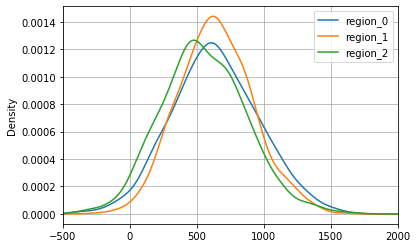

In [15]:
ax = bootstrap_profits_all_regions.plot.kde(grid=True, xlim=(-500, 2000))

In [16]:
# даже на графике видно, что регион №1 выигрывает по перспективности добычи, убедимся по статистическим показателям экономики
benchmarks_all_regions = pd.DataFrame() # внесем все статистики в dataframe для удобства вывода 
for region in regions:
    benchmarks_all_regions.loc['Средняя прибыль по прогнозу, млн. руб.', region] = mean_revenue_in_region[region]
    benchmarks_all_regions.loc['Вероятность убытка, %', region] = stats.percentileofscore(bootstrap_profits_all_regions[f'region_{region}'], 0)
    benchmarks_all_regions.loc['Нижняя оценка прибыли - 2.5% квантиль (95% доверительный интервал), млн. руб.', region] = bootstrap_profits_all_regions[f'region_{region}'].quantile(q=.025)
    benchmarks_all_regions.loc['Верхняя оценка прибыли - 97.5% квантиль (95% доверительный интервал), млн. руб.', region] = bootstrap_profits_all_regions[f'region_{region}'].quantile(q=.975)
    benchmarks_all_regions.loc['Вероятность прибыли более 1 млрд. руб., %', region] = 100 - stats.percentileofscore(bootstrap_profits_all_regions[f'region_{region}'], 1000)
benchmarks_all_regions.columns = ['Регион №0', 'Регион №1', 'Регион №2']
benchmarks_all_regions = benchmarks_all_regions.round(2)

In [17]:
benchmarks_all_regions

,Регион №0,Регион №1,Регион №2
"Средняя прибыль по прогнозу, млн. руб.",637.04,641.05,551.00
"Вероятность убытка, %",2.50,0.60,3.00
"Нижняя оценка прибыли - 2.5% квантиль (95% доверительный интервал), млн. руб.",12.39,120.27,-29.85
"Верхняя оценка прибыли - 97.5% квантиль (95% доверительный интервал), млн. руб.",1291.03,1209.03,1178.92
"Вероятность прибыли более 1 млрд. руб., %",13.60,9.40,7.40


## Выводы:
- В условиях проекта есть требование по максимальному уровню риска убытков - 2.5%. Данному требованию удовлетворяют только два региона: №0 и №1. В регионе №2 риск убытка больше и составляет 3%.
- Наилучшим кандидатом нам представляется регион №1, несмотря на гораздо более низкий средний уровень добычи по скважинам в сравнении с другими регионами, как было отмечено ранее. Причины следующие:
 - во-первых, риск убытков в данном регионе минимальный и составляет 0.6%;
 - во-вторых, средняя прибыль, полученная из нашего моделирования, составила 641 млн. руб. и это наибольшая величина из всех трех регионов;
 - в-третьих, с вероятностью 97.5% прибыль в данном регионе будет не ниже 120 млн. руб., тогда как для региона №0 с такой же степенью  уверенности можно утверждать, что проект будет безубыточным, а для региона №2 можно только утверждать, что возможный убыток будет ограничен 30 млн. руб.
- Стоит отметить, что регион №0, также прошедший отбор по критерию максимального риска убыточности, имеет более высокую вероятность большой прибыли:
 - во-первых, на графике видно, что для данного регоина вероятность получить прибыль более 1 млрд. руб. заметно выше, чем для региона №1, мы дополнительно посчитали вероятность такой большой прибыли для разных регионов - для региона №0 она составила 13,6%, тогда как для региона №1 - 9,4%;
 - во-вторых, 97,5% квантиль в данном регионе составляет чуть более 1,29 млрд. руб. прибыли и это  почти на 7% выше, чем 97,5% квантиль в регионе №1 (1,21 млрд. руб.). 
 
 Тем не менее, мы считаем регион №1 лучшим кандидатом по причинам, описанным выше.